In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [0]:
dataset, info = tfds.load("imdb_reviews/subwords32k", with_info=True,
                          as_supervised = True)
train, test = dataset['train'], dataset['test']

**Visualizing Dataset** This dataset is encoded using subword encoder so we have to decode each tensor using the encoder object to view it in text

In [0]:
encoder = info.features['text'].encoder

In [19]:
for x in train.take(5):
    print(f"Text: {encoder.decode(x[0].numpy())}")
    print(f"Sentiment: {('negative', 'positive')[x[1].numpy()]}", end='\n\n')

Text: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
Sentiment: negative

Text: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbi

In [20]:
encoder.vocab_size

32650

In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
EPOCHS = 10

**Preparing Dataset** We use padding to make each data point of equal size.

In [0]:
train_ds = (train
            .shuffle(BUFFER_SIZE)
            .padded_batch(BATCH_SIZE, padded_shapes=([None], [])))
test_ds = (test
           .padded_batch(BATCH_SIZE, padded_shapes=([None], [])))

**Training and Testing a sample model**

In [0]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim = encoder.vocab_size,output_dim = 64))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          2089600   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 2,163,969
Trainable params: 2,163,969
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics = ["accuracy"])

In [26]:
history = model.fit(train_ds, epochs=2,
                    validation_data = test_ds)

Epoch 1/2
391/391 [==============================] - 57s 145ms/step - loss: 0.6316 - accuracy: 0.6222 - val_loss: 0.4421 - val_accuracy: 0.8096
Epoch 2/2
391/391 [==============================] - 57s 146ms/step - loss: 0.3142 - accuracy: 0.8808 - val_loss: 0.3265 - val_accuracy: 0.8678


Function for plotting graphs

In [0]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.grid(True)
    plt.show()

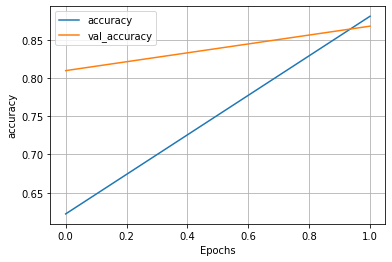

In [28]:
plot_graphs(history, 'accuracy')

**Comparision of SimpleRNN vs LSTM vs GRU models.** 
Keeping other things same in the model. This model is basic with no regularization or dropout

In [0]:
from tensorflow.keras.regularizers import l2
def sentiment_model(input_shape, rnn_layer_type = "LSTM"):
    """
    RNN based model for sentient prediction.

    Args:
    input_shape: input shape for the encoder layer. It is basically your vocabulary size
    rnn_layer_type: Type of the rnn layer to use. One of [`LSTM`, `RNN`, `GRU`]

    Returns:
    Uncompiled Keras model

    """
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Embedding(input_shape, output_dim = 128))
    rnn = None
    if rnn_layer_type == "RNN":
        rnn = tf.keras.layers.SimpleRNN(64)
    elif rnn_layer_type == "LSTM":
        rnn = tf.keras.layers.LSTM(64)
    elif rnn_layer_type == "GRU":
        rnn = tf.keras.layers.GRU(64)
    else:
        print("Enter valid rnn_layer_type: One of [`LSTM`, `RNN`, `GRU`]")
        return None
    model.add(tf.keras.layers.Bidirectional(rnn))
    model.add(tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=l2()))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(8, activation="relu", kernel_regularizer=l2()))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    return model

In [0]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2,
                                              min_delta=0.001,
                                              restore_best_weights=True)
callbacks_lst = [early_stop]

In [34]:
lstm_model = sentiment_model(encoder.vocab_size, rnn_layer_type="LSTM")
lstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  optimizer = tf.keras.optimizers.Adam(1e-4),
                  metrics = ["accuracy"]
                  )
lstm_history = lstm_model.fit(train_ds, epochs=EPOCHS,
                              validation_data = test_ds,
                              call_backs=callbacks_lst)

Epoch 1/10
391/391 [==============================] - 71s 180ms/step - loss: 1.4280 - accuracy: 0.5205 - val_loss: 1.2082 - val_accuracy: 0.6222
Epoch 2/10
391/391 [==============================] - 71s 182ms/step - loss: 1.0383 - accuracy: 0.6332 - val_loss: 0.9860 - val_accuracy: 0.5027
Epoch 3/10
391/391 [==============================] - 72s 183ms/step - loss: 0.8129 - accuracy: 0.7010 - val_loss: 0.6435 - val_accuracy: 0.8096
Epoch 4/10
391/391 [==============================] - 72s 183ms/step - loss: 0.5489 - accuracy: 0.8502 - val_loss: 0.4825 - val_accuracy: 0.8546
Epoch 5/10
391/391 [==============================] - 72s 184ms/step - loss: 0.4039 - accuracy: 0.9038 - val_loss: 0.4254 - val_accuracy: 0.8691
Epoch 6/10
391/391 [==============================] - 72s 183ms/step - loss: 0.3320 - accuracy: 0.9249 - val_loss: 0.4208 - val_accuracy: 0.8698
Epoch 7/10
391/391 [==============================] - 71s 183ms/step - loss: 0.2717 - accuracy: 0.9462 - val_loss: 0.4098 - val_ac

In [35]:
lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 128)         4179200   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 520       
_________________________________________________________________
dropout_7 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

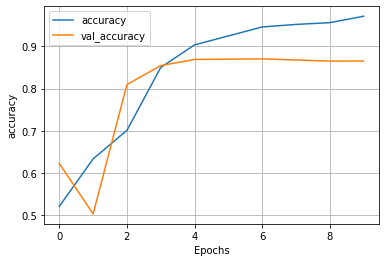

In [36]:
plot_graphs(lstm_history, 'accuracy')

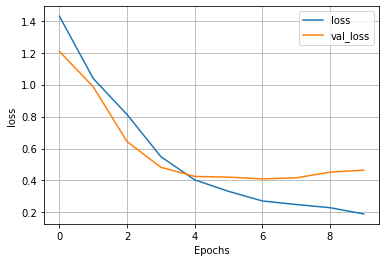

In [37]:
plot_graphs(lstm_history, 'loss')

In [39]:
gru_model = sentiment_model(encoder.vocab_size, rnn_layer_type="GRU")
gru_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  optimizer = tf.keras.optimizers.Adam(1e-4),
                  metrics = ["accuracy"]
                  )
gru_history = gru_model.fit(train_ds, epochs=EPOCHS,
                            validation_data = test_ds,
                            callbacks=callbacks_lst)

Epoch 1/10
391/391 [==============================] - 70s 178ms/step - loss: 1.4375 - accuracy: 0.5063 - val_loss: 1.2240 - val_accuracy: 0.5483
Epoch 2/10
391/391 [==============================] - 69s 176ms/step - loss: 1.0772 - accuracy: 0.5662 - val_loss: 0.9477 - val_accuracy: 0.6221
Epoch 3/10
391/391 [==============================] - 69s 177ms/step - loss: 0.7962 - accuracy: 0.7162 - val_loss: 0.7434 - val_accuracy: 0.7220
Epoch 4/10
391/391 [==============================] - 68s 175ms/step - loss: 0.5604 - accuracy: 0.8362 - val_loss: 0.5270 - val_accuracy: 0.8235
Epoch 5/10
391/391 [==============================] - 68s 175ms/step - loss: 0.4135 - accuracy: 0.8962 - val_loss: 0.5063 - val_accuracy: 0.8145
Epoch 6/10
391/391 [==============================] - 68s 175ms/step - loss: 0.3300 - accuracy: 0.9302 - val_loss: 0.4672 - val_accuracy: 0.8372
Epoch 7/10
391/391 [==============================] - 68s 174ms/step - loss: 0.2726 - accuracy: 0.9493 - val_loss: 0.4688 - val_ac

In [40]:
gru_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 128)         4179200   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 128)               74496     
_________________________________________________________________
dense_19 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 520       
_________________________________________________________________
dropout_11 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                

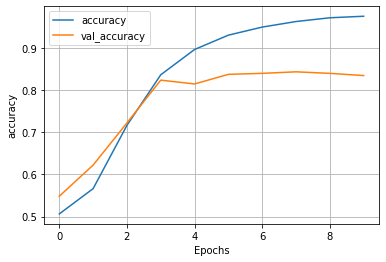

In [41]:
plot_graphs(gru_history, 'accuracy')

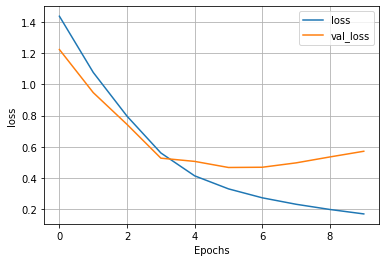

In [42]:
plot_graphs(gru_history, 'loss')